# Regressão!
## Alan Silva Furquim - 200049 / Vitor Augusto de LIma Soares 200327

Esse notebook contém todas as funções necessária para realizar a **regressão** no em um dataframe com dados do **Walmart**, apresentando as seguintes informações:
-   **Store** - O número único de cada loja
-   **Date** - A semana das vendas
-   **Weekly_Sales** - O total de vendas na semana da respectiva loja
-   **Holiday_Flag** - Mostra se a respectiva semana tem feriados ou não. 1- Tem feriados na semana, 2- Não tem feriados na semana
-   **Temperature** - A temperatura no dia da venda
-   **Fuel_Price** - O valor do combustivel da região da loja
-   **CPI** – Índice de preço ao consumidor
-   **Unemployment** - Taxa de desemprego
-  **Lista de feriados**:
	-  **Super Bowl**: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
	-	**Labour Day**: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
	-	 **Thanksgiving**: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\
	-	**Christmas**: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


In [499]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

plt.style.use(style='fivethirtyeight')
%matplotlib inline


In [500]:
data = pd.read_csv(r'regressao_walmart.csv')

## Verificando quantidade e tipos de dados dentro do dataframe

In [501]:
display(data.head(n=5))
display(data.describe())

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [502]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [503]:
#verificando a diversidade de valores em cada coluna do dataframe
print('Total de valores por coluna:')
for coluna in data:
    unicos = data[coluna].unique()
    valores = len(unicos)
    if len(unicos) < 10:
        print(f"    -{coluna}: {valores}->{unicos}")
    else:
        print(f"    -{coluna}: {valores}")
        

Total de valores por coluna:
    -Store: 45
    -Date: 143
    -Weekly_Sales: 6435
    -Holiday_Flag: 2->[0 1]
    -Temperature: 3528
    -Fuel_Price: 892
    -CPI: 2145
    -Unemployment: 349


In [504]:
#verificando se existem valores em branco
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

### É possível concluir que o dataframe nao tem valores faltando

-------------------------
# Featuring engineering

In [505]:

#Criando colunas de data para ter mais parametros na hora do treinamento e previsão.
data['Date'] = pd.to_datetime(data['Date'], format = "%d-%m-%Y")
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['week'] = data['Date'].dt.isocalendar().week

In [506]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   year          6435 non-null   int32         
 9   month         6435 non-null   int32         
 10  week          6435 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(5), int32(2), int64(2)
memory usage: 484.0 KB


In [507]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
 8   year          6435 non-null   int32         
 9   month         6435 non-null   int32         
 10  week          6435 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(5), int32(2), int64(2)
memory usage: 484.0 KB


# EDA

In [508]:
display(data.describe())

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,week
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.0
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,6.447552,25.818182
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.0
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000,14.0
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000,26.0
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000,38.0
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,52.0
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,3.238308,14.129201


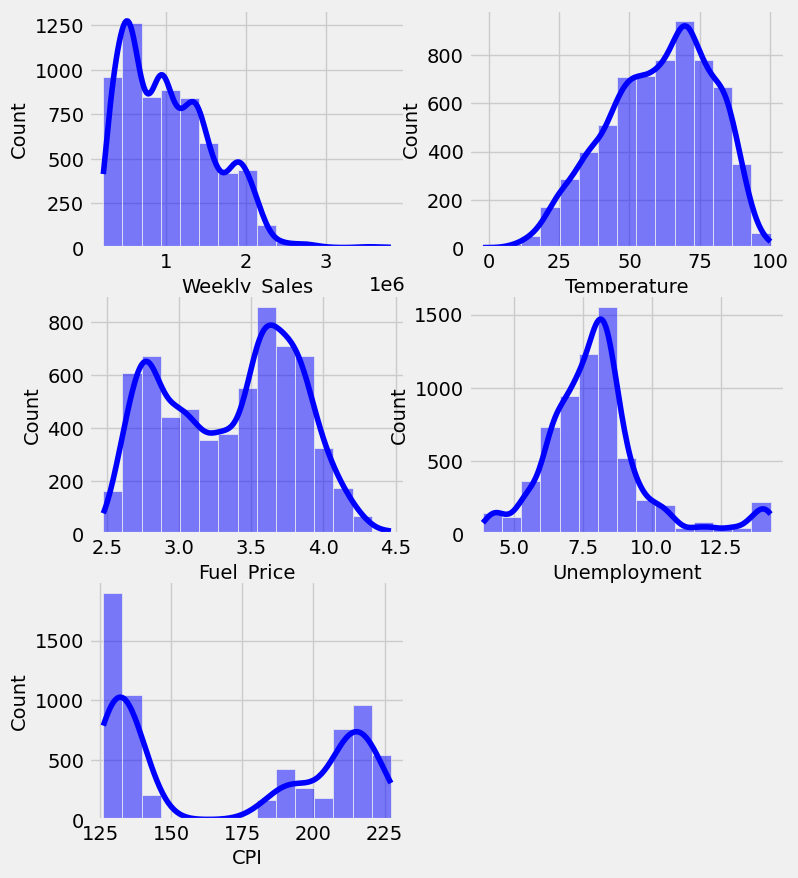

In [509]:
columns = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'Unemployment', 'CPI']
plt.figure(figsize=(8, 10))
for i,col in enumerate(columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data = data, x = col, kde = True, bins = 15, color = 'b')
plt.show()

### É possível observar com o gráfico que no dataframe existem diferentes tipos de distribuição, de acordo com cada coluna

In [510]:
data['year'].value_counts()

year
2011    2340
2010    2160
2012    1935
Name: count, dtype: int64

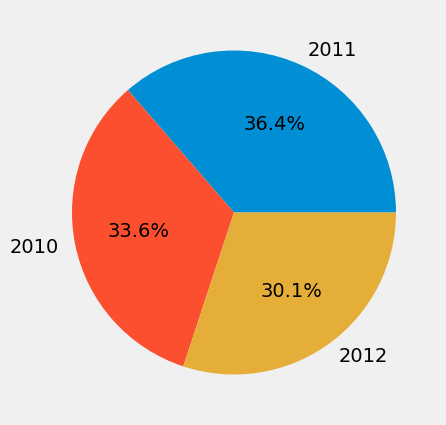

In [511]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.pie(data['year'].value_counts().values,
          labels = data['year'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()

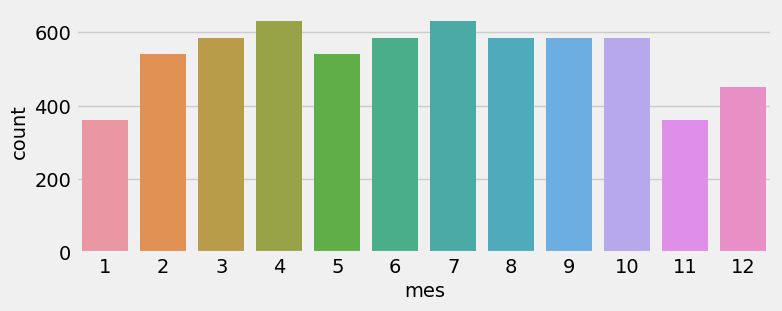

In [512]:
plt.figure(figsize=(8, 3))
sns.countplot(data = data, x = 'month')
plt.xlabel('mes')
plt.show()

### Até agora é possivel ver que a maioria dos registros de vendas aconteceram em 2011, e os meses com mais registros são abril e julho.

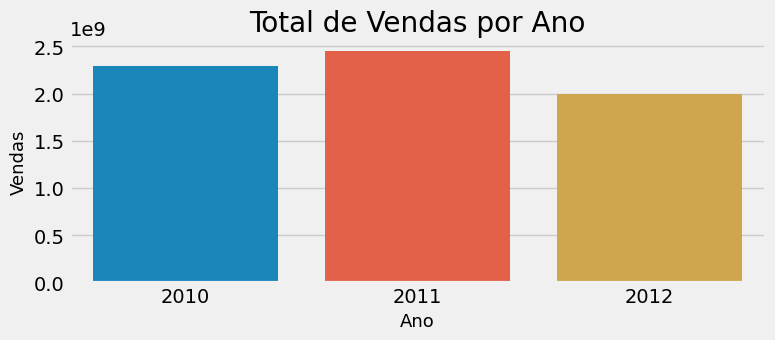

In [513]:
plt.figure(figsize = (8, 3))
sns.barplot(data = data,
            x = 'year',
            y = 'Weekly_Sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total de Vendas por Ano')
plt.xlabel('Ano', size = 13)
plt.ylabel('Vendas', size = 13)
plt.show()

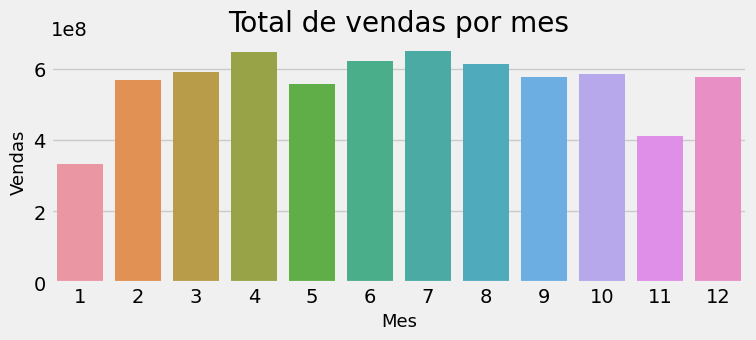

In [514]:
plt.figure(figsize = (8, 3))
sns.barplot(data = data,
            x = 'month',
            y = 'Weekly_Sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total de vendas por mes')
plt.xlabel('Mes', size = 13)
plt.ylabel('Vendas', size = 13)
plt.show()

### Conclusão: na maioria das vezes, o maior numero de registro de vendas significa o maior valor vendido.

### Agora vamos verificar quais lojas mais vendem

Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
10    2.716177e+08
27    2.538559e+08
6     2.237561e+08
1     2.224028e+08
39    2.074455e+08
19    2.066349e+08
31    1.996139e+08
23    1.987506e+08
24    1.940160e+08
11    1.939628e+08
28    1.892637e+08
41    1.813419e+08
32    1.668192e+08
18    1.551147e+08
22    1.470756e+08
12    1.442872e+08
26    1.434164e+08
34    1.382498e+08
40    1.378703e+08
35    1.315207e+08
8     1.299512e+08
17    1.277821e+08
45    1.123953e+08
21    1.081179e+08
25    1.010612e+08
43    9.056544e+07
15    8.913368e+07
7     8.159828e+07
42    7.956575e+07
9     7.778922e+07
29    7.714155e+07
16    7.425243e+07
37    7.420274e+07
30    6.271689e+07
3     5.758674e+07
38    5.515963e+07
36    5.341221e+07
5     4.547569e+07
44    4.329309e+07
33    3.716022e+07
Name: Weekly_Sales, dtype: float64

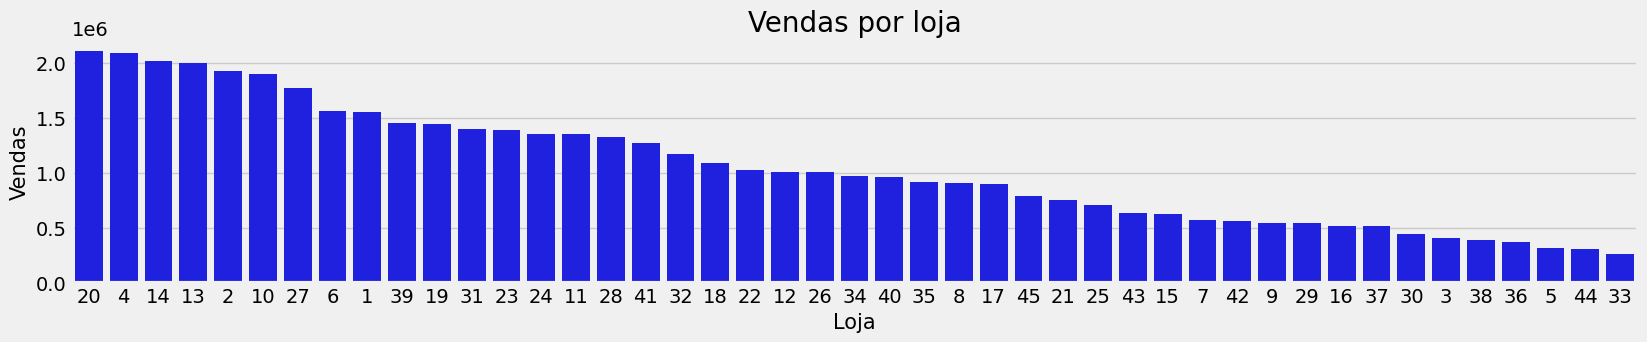

In [515]:
vendas_por_loja = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending = False)
display(vendas_por_loja)

plt.figure(figsize = (18, 3))
sns.barplot(data = data,
            x = 'Store',
            y = 'Weekly_Sales',
            order = vendas_por_loja.index,
            ci = False, color='b')

# Add labels and title
plt.title('Vendas por loja', size = 20)
plt.xlabel('Loja', size = 15)
plt.ylabel('Vendas', size = 15)
plt.show()

### Existe uma grande diferença nas vendas por loja.
---
Para tirar mais conclusões, vamos analisar a relação de venda e taxa de desemprego, que parece ser um principal motivo para diminuição de receita semanal.

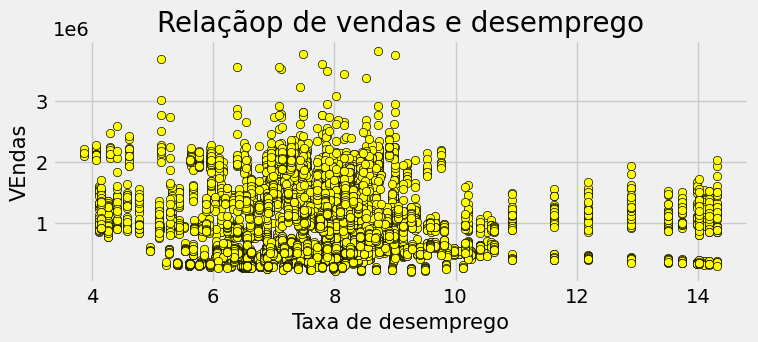

In [516]:
plt.figure(figsize = (8, 3))
sns.scatterplot(data = data,x = 'Unemployment',y = 'Weekly_Sales',color = 'yellow',edgecolor = 'black')

plt.title('Relaçãop de vendas e desemprego', size = 20)
plt.xlabel('Taxa de desemprego', size = 15)
plt.ylabel('VEndas', size = 15)
plt.show()

### Quanto maior a taxa de desempregro, menos vendas, então essas colunas estão diretamente ligadas.
---

### Por fim, vamos verificar a correlação das vendas com as outras colunas.



Matriz de correlação: 


,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Weekly_Sales,1.000000,-0.063810,0.009464,-0.072634,-0.106176
Temperature,-0.063810,1.000000,0.144982,0.176888,0.101158
Fuel_Price,0.009464,0.144982,1.000000,-0.170642,-0.034684
CPI,-0.072634,0.176888,-0.170642,1.000000,-0.302020
Unemployment,-0.106176,0.101158,-0.034684,-0.302020,1.000000


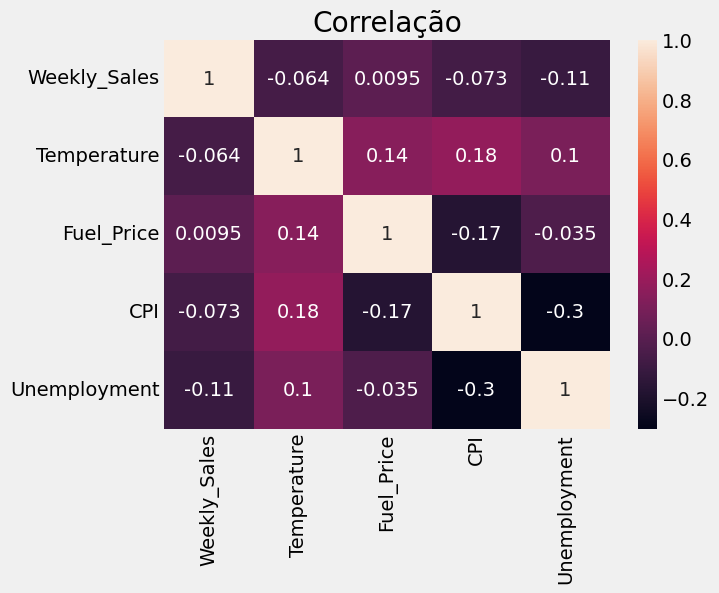

In [517]:
df_correlation = data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()

print('\n\nMatriz de correlação: ')
display(df_correlation)

sns.heatmap(df_correlation,
            annot=True,
            xticklabels=df_correlation.columns,
            yticklabels=df_correlation.columns)

plt.title('Correlação')
plt.show()


### Analisando o gráfico, é possivel confirmar que a maior correlação das vendas é com o desemprego, como abordado acima.

---
# Pré processamento
### Vamos começar removendo as colunas desnecessárias para essa etapa.

In [518]:
#criando um dataframe novo para nao perder dados do antigo.
data_copy = data.copy()

In [519]:
data_copy.drop(['Date', 'year', 'month'], axis = 1, inplace = True)

In [520]:
#Convertendo os tipos das colunas para objeto para serem tratadas como categoricas
data_copy['Store'] = data_copy['Store'].astype('object')
data_copy['Holiday_Flag'] = data_copy['Holiday_Flag'].astype('object')

### Verificar e corrigir tipos errados de colunas

In [521]:
data_copy.dtypes

Store            object
Weekly_Sales    float64
Holiday_Flag     object
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
week             UInt32
dtype: object

In [522]:
data_copy['week'] = data_copy['week'].astype('int32')

In [523]:
data_copy.dtypes

Store            object
Weekly_Sales    float64
Holiday_Flag     object
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
week              int32
dtype: object

### Verificando outliers para realizar a remoção, a fim de aumentar a precisão

0 Fuel_Price
1 Temperature
2 CPI
3 Unemployment


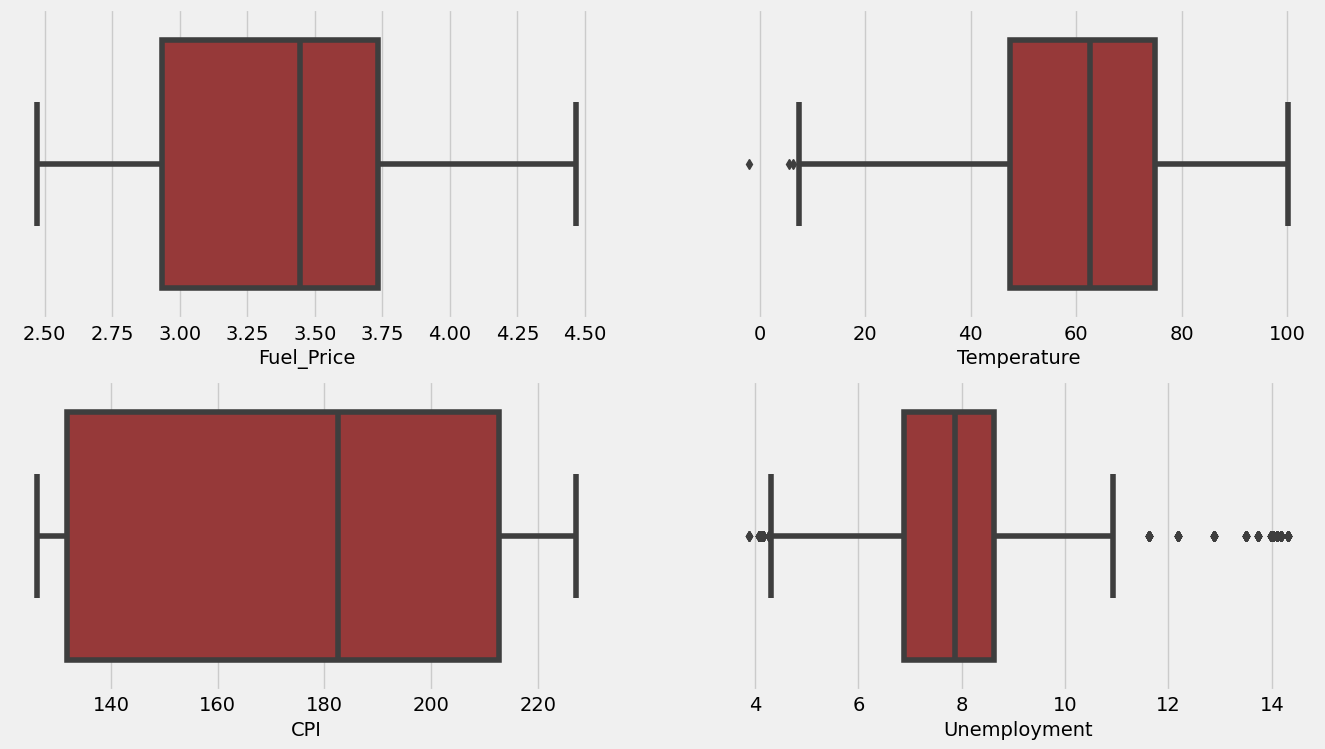

Number of data rows:  6435


In [524]:
cols = ['Fuel_Price', 'Temperature', 'CPI', 'Unemployment']
plt.figure(figsize=(15,13))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_copy, x = col, color = 'brown')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

In [525]:
data_copy.Temperature.sort_values(ascending = True)[0:10]

910     -2.06
3626     5.54
2336     6.23
959      7.46
5628     9.51
3575     9.55
906     10.09
909     10.11
911     10.24
858     10.53
Name: Temperature, dtype: float64

In [526]:
data_copy.loc[data_copy.Unemployment < 5]['Unemployment'].describe()

count    213.000000
mean       4.371164
std        0.251683
min        3.879000
25%        4.156000
50%        4.308000
75%        4.584000
max        4.954000
Name: Unemployment, dtype: float64

### menos que 7 é considerado outlier na temperatura, no desemprego foram considerados outliers os valores menores que a media acima e maiores que 11 (de acordo com o grafico).

In [527]:
#removendo de acordo com o grafico acima
data_copy.drop(data_copy[data_copy['Temperature'] < 7].index, axis = 0, inplace = True)
data_copy.drop(data_copy[data_copy['Unemployment'] < 4.3].index, axis = 0, inplace = True)
data_copy.drop(data_copy[data_copy['Unemployment'] > 11].index, axis = 0, inplace = True)

0 Fuel_Price
1 Temperature
2 CPI
3 Unemployment


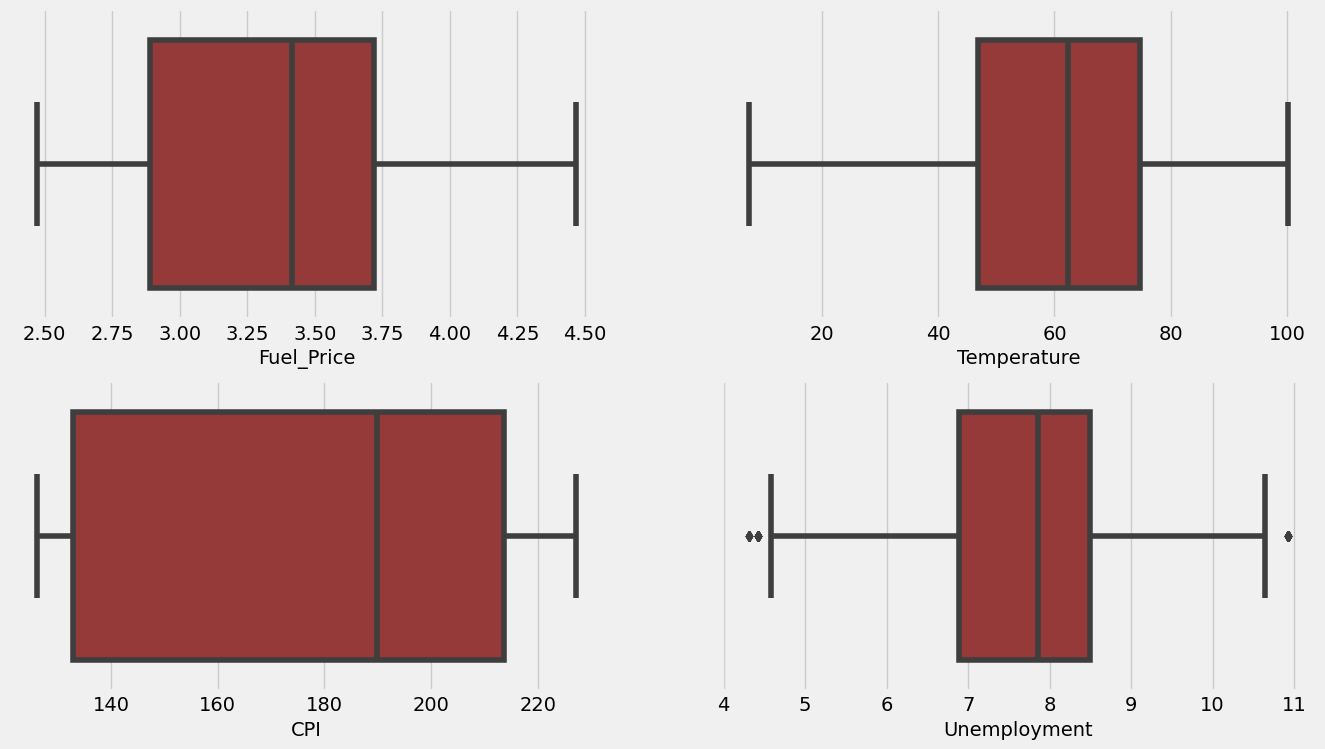

Number of data rows:  5951


In [528]:
#Plotando o grafico novamente para ver se realmente nao temos mais outliers
cols = ['Fuel_Price', 'Temperature', 'CPI', 'Unemployment']
plt.figure(figsize=(15,13))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_copy, x = col, color = 'brown')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

### ainda restaram outliers no desemprego, porem um está balanceando o outro.
---
# Separando os dados entre treino e teste

In [529]:
# Separando os dados entre numero e nao numericos
num_values = data_copy.select_dtypes('number').columns.to_list()
num_values.remove('Weekly_Sales')

not_num_features = data_copy.select_dtypes('object').columns.to_list()

print(f'Valores numericos : {num_values}')
print(f'Valores nao numericos: {not_num_features}')

Valores numericos : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'week']
Valores nao numericos: ['Store', 'Holiday_Flag']


In [530]:
X = data_copy[num_values]
y = data_copy['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [531]:
def model_evaluation(estimator, Training_Testing, X, y):

    ''' This function is used to evaluate the model through RMSE and R2'''

    # Y predict of X train or X test
    predict_data = estimator.predict(X)

    print(f'{Training_Testing} Accuracy: \n')
    print(f'-> Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}')
    print(f'-> R-Squere score Training: {round(r2_score(y, predict_data) * 100, 2)} % \n')

## Regressão Linear

In [532]:
#função de plot aprendida na aula
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Épocas')
    plt.ylabel('Erro')
    plt.legend()
    plt.grid(True)

In [533]:
#criando o modelo e colocando os dados
model = LinearRegression()

model.fit(X_train, y_train)

normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)

#criando uma sequancia em keras
model = keras.Sequential([
    normalizer,
    layers.Dense(1)
])

#compilando modelo de treino
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

history = model.fit(X_train, y_train,epochs=16, validation_data=(X_test, y_test))


Epoch 1/16
131/131 [==============================] - 0s 2ms/step - loss: 1052817.5000 - val_loss: 1046768.6875
Epoch 2/16
131/131 [==============================] - 0s 1ms/step - loss: 1052804.2500 - val_loss: 1046755.5000
Epoch 3/16
131/131 [==============================] - 0s 1ms/step - loss: 1052791.1250 - val_loss: 1046742.3750
Epoch 4/16
131/131 [==============================] - 0s 979us/step - loss: 1052778.2500 - val_loss: 1046729.2500
Epoch 5/16
131/131 [==============================] - 0s 1ms/step - loss: 1052765.1250 - val_loss: 1046716.2500
Epoch 6/16
131/131 [==============================] - 0s 1ms/step - loss: 1052752.0000 - val_loss: 1046703.0000
Epoch 7/16
131/131 [==============================] - 0s 989us/step - loss: 1052738.7500 - val_loss: 1046690.1875
Epoch 8/16
131/131 [==============================] - 0s 1ms/step - loss: 1052725.8750 - val_loss: 1046676.8125
Epoch 9/16
131/131 [==============================] - 0s 928us/step - loss: 1052712.7500 - val_loss:

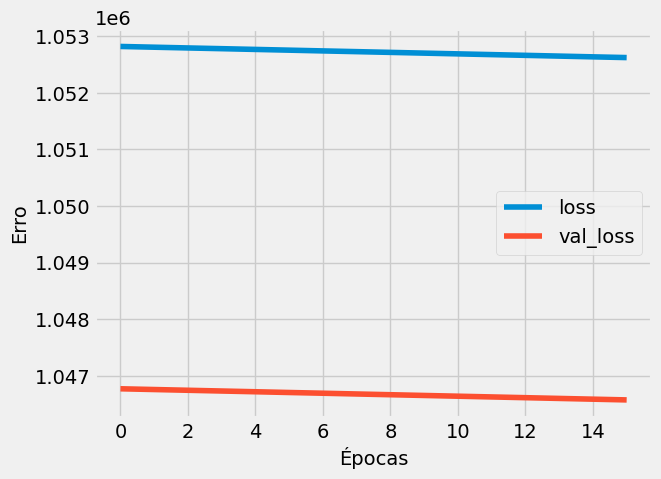

In [534]:
#plotando as 16 epocas do modelo
plot_loss(history)


In [535]:
#Calculando MSE e validações cruzadas para as predições de vendas
y_pred = model.predict(X_test)
print("MSE: " , mean_squared_error(y_test, y_pred))
print("R2: " , r2_score(y_test, y_pred))

56/56 [==============================] - 0s 619us/step


MSE:  1416015630089.3318
R2:  -3.415356847766186


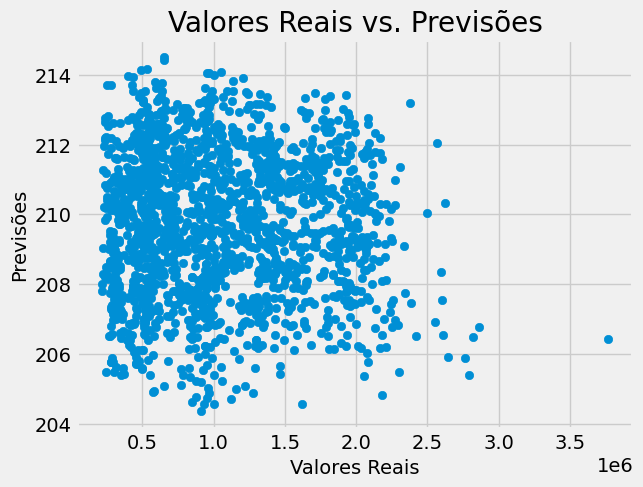

In [536]:
# Visualize os resultados
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Valores Reais vs. Previsões')
plt.show()

### COnclusão: o modelo nao aprendeu bem, e previu valores distantes dos reais, provavelmente por conta de complexidade do dataset

---
# Arvore de decisao

### Refazendo tratamento para garantir que nenhum dado foi perdido na ultima parte

In [537]:
data_copy = data.copy()
data_copy.drop(['Date', 'year', 'month'], axis = 1, inplace = True)
data_copy['Store'] = data_copy['Store'].astype('object')
data_copy['Holiday_Flag'] = data_copy['Holiday_Flag'].astype('object')
data_copy['week'] = data_copy['week'].astype('object')

In [538]:
data_copy.drop(data_copy[data_copy['Temperature'] < 7].index, axis = 0, inplace = True)
data_copy.drop(data_copy[data_copy['Unemployment'] < 4.4].index, axis = 0, inplace = True)
data_copy.drop(data_copy[data_copy['Unemployment'] > 11].index, axis = 0, inplace = True)

### Separando entre train e teste

In [539]:
X = data_copy.drop('Weekly_Sales', axis = 1)
y = data_copy['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Separando numericos e categoricos

In [540]:
num_features = data_copy.select_dtypes('number').columns.to_list()
num_features.remove('Weekly_Sales')

cat_features = data_copy.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Categorical Features: ['Store', 'Holiday_Flag', 'week']


### Transformando os dados para nao dar o erro de 'continuous value'

In [541]:
preprocessor = ColumnTransformer([
                                  ('num_features', StandardScaler(), num_features),
                                  ('cat_features', BinaryEncoder(), cat_features),
                                ])

# Fitting the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['Temperature', 'Fuel_Price', 'CPI',
                                  'Unemployment']),
                                ('cat_features', BinaryEncoder(),
                                 ['Store', 'Holiday_Flag', 'week'])])

In [542]:
X_train_transformed = preprocessor.transform(X_train)

X_test_transformed = preprocessor.transform(X_test)

### Criando o modelo

In [543]:
tree = DecisionTreeRegressor()
tree.fit(X_train_transformed, y_train)

DecisionTreeRegressor()

In [544]:
#Verificando a acuracia do treino com uma função pronta
model_evaluation(tree, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 0.0
-> R-Squere score Training: 100.0 % 



### Com o ótimo resultado de 100% de acuracia, o arvore de decisão de mostrou extremamente eficiente nesse dasaset, provavelmente devido ao formato dos dados.

---
# Redes Neurais

In [546]:
#Normalizando os dados de treino
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train_transformed)

#criando um modelo sequencial no keras
model = keras.Sequential([
    normalizer,
    layers.Dense(10),
    layers.Dense(7, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)
])

model.summary()

#compilando o modelo keras criado acima
model.compile(optimizer='adam',
              loss='mean_absolute_error')

#treinando o modelo criado com o numero de epocas correto.
history = model.fit(
    X_train_transformed, y_train,
    epochs=16,
    validation_split = 0.2,
    batch_size=8,
    verbose=0
    )


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_20 (Normaliz  (None, 18)                37        
 ation)                                                          
                                                                 
 dense_28 (Dense)            (None, 10)                190       
                                                                 
 dense_29 (Dense)            (None, 7)                 77        
                                                                 
 dense_30 (Dense)            (None, 5)                 40        
                                                                 
 dense_31 (Dense)            (None, 1)                 6         
                                                                 
Total params: 350 (1.37 KB)
Trainable params: 313 (1.22 KB)
Non-trainable params: 37 (152.00 Byte)
____________________

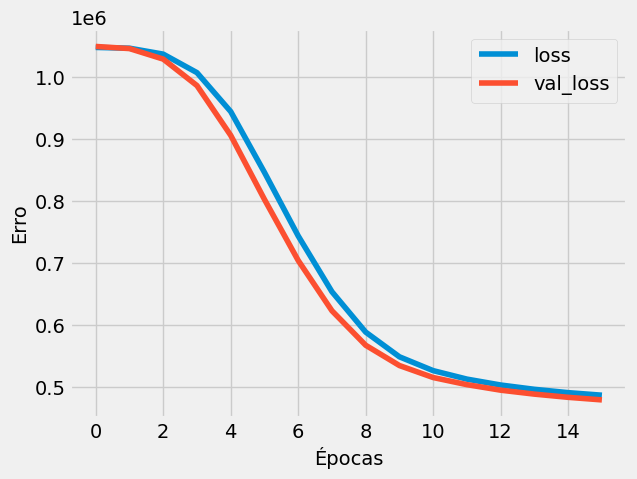

In [547]:
plot_loss(history)

### Variação pequena entre teste e treino, significa que foi uma boa predição

In [549]:
y_pred = model.predict(X_test_transformed).reshape(-1)
print(y_pred)

38/38 [==============================] - 0s 685us/step
[ 871752.8   884644.44  694140.3  ...  805447.94 1091497.9   893756.6 ]


In [550]:
model.evaluate(X_test_transformed, y_test)

38/38 [==============================] - 0s 892us/step - loss: 468839.4375


468839.4375

In [552]:
y_test.mean()

1051858.4139814815

In [551]:
y_pred.mean()

871676.5

## Conclusão:
### Os 3 modelos funcionaram, embora uns melhores que outros (Regressão linear com precisão extremamente baixa e Arvore de decisão com precisão de 100%), foi de ótimo aprendizado sobre como utilizar de maneira adequada as bibliotecas de IA, que vai ser um ótimo ganho em conhecimento para nossa vida profissional.